# Case Study 3 workout (continued)
The actual coding of the optimization

### Repeat of code from previous notebook.
`2000.22.Nov.19`

In [1]:
# Run the code written in notebook 02
%run 'baker-cs34-functions.py'

In [2]:
#- Rip the boundary coordinates from the .yaml file -#
fn = "iea37-boundary-cs3.yaml"
bndryPts = getTurbAtrbtYAML(fn)
#print(bndryPts)

## Interpolating and visualizing the grids
`1549.05.Dec.19`

This time we need to save the formulas created.

I'm having difficulty finding how to make an `np.recarray()` of the correct `interp1d` data type, so I can initialize an empty array to hold the ones that are created.

Though I did figure out how to save all the helper functions in a separate file and use `%run` so they would be here referenced, instead of copy/pasting the entire thing

FINALLY figured it out initializing the array with `np.empty(numSides, interp1d)` with is of `NoneType`
`1746.05.Dec.19`

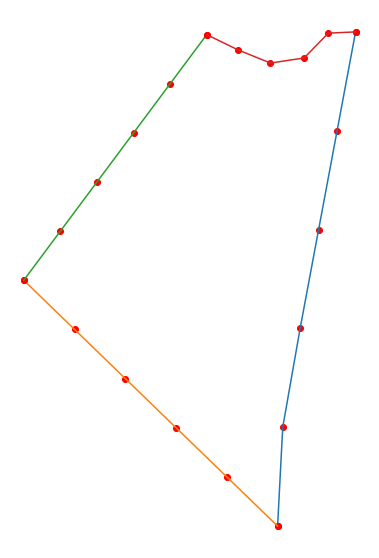

In [3]:
#-- Plot the boundary (modelled with splines) --#
displaySize = np.recarray(1, coordinate)
displaySize.x = 10
displaySize.y = 10
numLinspace = 100
numGridLines = 5                   # How many gridlines we'll use for the visualization
clsdBP = closeBndryList(bndryPts)
vertexList = [0, 6, 8, 9, 18]       # Hard code the vertices (though this could be done algorithmically)
numSides = len(vertexList) - 1      # The number of sides for our original coordinate system. Usually (4) to Euclidean, but could be any number)

#-- Plot our space (with splines) --#
splineList = np.empty(numSides, interp1d)                  # Init. array IOT save the Splines for each "side"
xList = np.empty([numSides, numLinspace], np.float64)      # Init. array to hold the x-values of each discretized spline (for plotting)
xGridList = np.empty([numSides, numGridLines], np.float64) # Init. array to hold the x-values of each discretized spline (for plotting)
segCoordList = np.recarray([numSides, numGridLines+1], coordinate)

#- Create the splines for each side (<numSides> many)-#
for i in range(numSides):
    BndPts = clsdBP[vertexList[i]:(vertexList[i+1]+1)]      # Extract the points for the "edge" we want
    BndrySegCoords = sliceBoundary(BndPts, numGridLines)    # Reparameterize the boundry to be defined by <numDivs> many points
    segCoordList[i] = BndrySegCoords
    printVerticies(BndrySegCoords, list(range(numGridLines+1)), 'red')
    splineList[i] = interp1d(BndrySegCoords.x, BndrySegCoords.y, kind='linear')   # Make the spline using NumPy's <interp1d>
    xList[i] = np.linspace(BndrySegCoords[0].x, BndrySegCoords[len(BndrySegCoords)-1].x, num=numLinspace, endpoint=True) # Record the correct x-values for later visualization
    xGridList[i] = np.linspace(BndrySegCoords[0].x, BndrySegCoords[len(BndrySegCoords)-1].x, num=numGridLines, endpoint=True) # Record the correct x-values for later visualization
    plt.hold = True
    printBoundaryArray(xList[i], splineList[i](xList[i]), displaySize)

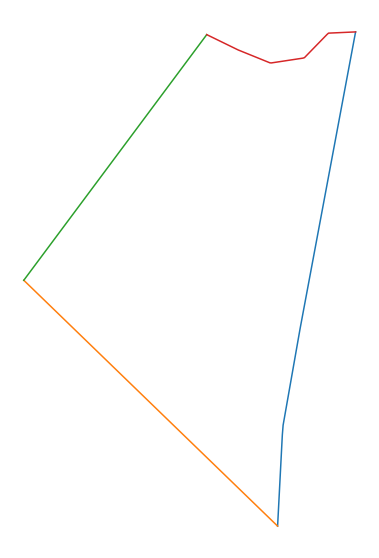

In [4]:
#- Plot the splines -#
for i in range(numSides):
    plt.hold = True
    printBoundaryArray(xList[i], splineList[i](xList[i]), displaySize)

### Aside (thoughts on gridding)
`1841.05.Dec.19`

Now I have to figure out how to grid it so it contours properly. Eduardo attempted this with a creative method, but I don't think it's completly accurate. The figure from his earlier referenced jupyter notebook is here included:
<img src="figures/eduardo-grid.png" alt="cs3 boundary with example turbine placement" width="800"/>
As one can see, the center is quite strictly gridded, and the outtermost grid isn't contoured quite correctly. I'll have to figure out how to meld this a bit "better"

Drawing it out on the markerboard, I want it to look like this:

<img src="figures/translation.jpg" alt="cs3 boundary with example turbine placement" width="800"/>

Where the right grid is the Euclidean space, and the left object is the projected translation space. NOte that coordinates are normalized between zero and one.

Also I just figured out how to properly insert an image into a Jupyter Notebook. `1816.05.Dec.19`

## Interpolating and visualizing the grids (continued)
`1843.05.Dec.19`

First I'll need to sub-divide each splined side into say 30 points along each line, then plot all interpolated "grid lines" using those points as vertices.

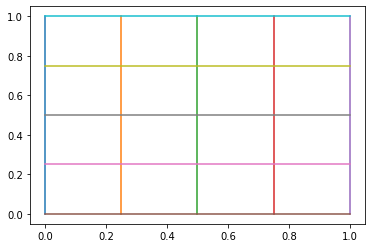

In [5]:
#-- Create and plot the Euclidean space (normalized from 0 to 1) --#
vertLineArrayEuc = np.recarray([numGridLines,numLinspace], coordinate)
horizLineArrayEuc = np.recarray([numGridLines,numLinspace], coordinate)

xVertGridValsEuc = np.linspace(0, 1, numGridLines, endpoint=True)
yHorizGridValsEuc = np.linspace(0, 1, numGridLines, endpoint=True)
gridLinspace = np.linspace(0, 1, numLinspace, endpoint=True)

# Get our vertical lines
for i in range(numGridLines):        # Loop through all x-values
    for k in range(numLinspace):        # Loop through all y-values in our linspace
        vertLineArrayEuc[i][k].x = xVertGridValsEuc[i]
        vertLineArrayEuc[i][k].y = gridLinspace[k]
    plt.plot(vertLineArrayEuc[i].x,vertLineArrayEuc[i].y)

# Get our horizontal lines
for j in range(numGridLines):           # Loop through all y-values
    for i in range(numLinspace):        # Loop through all x-values in our linspace
        horizLineArrayEuc[j][i].x = gridLinspace[i]
        horizLineArrayEuc[j][i].y = yHorizGridValsEuc[j]
    plt.plot(horizLineArrayEuc[j].x,horizLineArrayEuc[j].y)        

### Making divisions along the splines
`1957.05.Dec.19`

Now that I've got the euclidean grid lines sorted, I've got to figure out how to project them onto the new boundaries.<br/>
First I'll just make the right endpoints on the spline boundaries.

In [7]:
# Create grid lines along the spline
#for i in range(numSides):
i = 0
print(segCoordList[i])

[(10363.8      , 6490.3       ) (10126.213638 , 5219.81985987)
 ( 9888.627276 , 3949.33971975) ( 9651.040914 , 2678.85957962)
 ( 9427.1883086, 1406.30879059) ( 9361.3      ,  137.1       )]


I've got a problem where I added a point to the end, so instead of 5 there are 6 points. I'll have to sort it out after I get it working.

10126.21363800053
8708.695083507413
6568.7
8854.388711232217


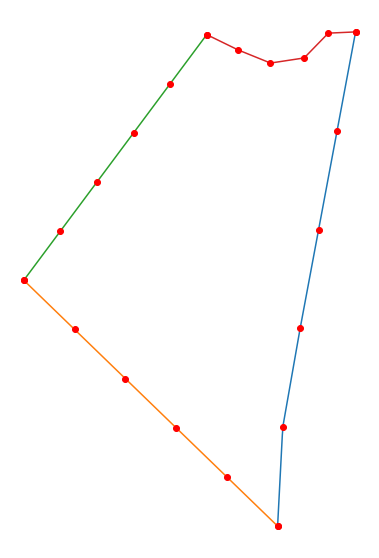

In [8]:
#- Plot the splines -#
for i in range(numSides):
    plt.hold = True
    printBoundaryArray(xList[i], splineList[i](xList[i]), displaySize)
    printVerticies(segCoordList[i], list(range(numGridLines+1)), 'red')

In [ ]:
# Use splines [0] and [2] map to the vertical euclidean boundaries, and [1] and [4] map to the horizontal euclidean boundaries

#for x in range(numGridLines)        # Loop through all x-values
#`1843.05.Dec.19`    for y in range(numGridLines)    # Loop through all y-values

## Optimization of cs3